<center> <h1>XXX Datathon - Team n°1</h1> </center>

# In this Notebook

We will try to undestand which features are the most relevant for our ```PREMIUM``` prediction. We will follow the following theory.

<img src="img/feat_selection.png" width=600 /> 




Source of the image: 
[click here](https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/).

In our case, we will look at different algorithms presented above for feature reduction.

- Intrinsic method:
    - Random Forest Regressor Features Importances
- Wrapper method:
    - Recursive Feature Elimination (RFE)
- Filter method:
    - Pearson's Correlation
    
The different types of correlation possible are defined on the tree on the image below.

<img src="img/cat.png" width=600 /> 


We will need to separe our analysis for both numerical and categorical variables.

However, before applying any algorithm, we will remove the redudant features wich are heavily correlated as they may significantly affect our models performance.

# <font color='darkorange'>Imports </font>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Scikit learn models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, f_regression

pd.set_option('display.max_columns', 150)
sns.set_style("darkgrid")
sns.set_palette("Blues")

# <font color='darkorange'>Data Loading </font>

In [2]:
df = pd.read_csv('data/processed_data_train.csv')
X = df.drop(columns=['PREMIUM'])
y = df['PREMIUM']
df.head()

,FACUL_NUM,DIVISION_NUM,weighted_hazard,SEGMENT_LOB,UWYEAR,CT_PERIOD,MAINOCCUPANCY,SECTOR,BUSINESSUNIT,UWCENTER,SCOPE_PERILS,SUBSIDIARY,PARTTYPE,GUARANTEE,MAIN_PRICING_CATEG,BI_TYPE,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,TOTALINSUREDVALUE,NBLOCS,OIL,LIMIT,ATTACHMENT,XXX_SHARE,PREMIUM,MODELED_CAT_EXPLOSS,DISCOUNTS,DEDUCTION,EXT_EXPENSE,WORDING,QUALITY_RISK_MGT,ASSET_QUALITY,BI_MITIGATION,MB_QUALITY,TXCHANGE,FXRATEUSD,TOP_MPL,TOP_FMLS,PD_price(M),BI_time(Days),Both_price(M),PD_percent_loss (%),COVER_BI,GEO_MARKET_SEGMENT,UWYEAR_label,INCEPTION_month,uw_index,financial_ratio
0,02F062851,4,0.021181,Ppty Non Energy,2019,12,Precious Metals Mines,BS Energy,BS Energy,EMEA,All Risks,XXX REASSURANCE,Excess of Loss,EU,Mining - Hard Rock,Loss of profit,12.0,4.332659e+08,1.811347e+08,6.144006e+08,1,0.0,3.585254e+08,6598627.50,0.09990,51556.785174,0.0,0.0,0.090927,0.090927,Standard,Average,Average,Average,Average,0.879817,1.0,1.987311e+08,0.0,0.9,30.0,0.0,0.0,True,Latin America,1,4,0.009348,1.076494
1,11F008861,1,0.493284,Ppty Non Energy,2017,12,Precious Metals Mines,BS Energy,BS Energy,LAC,All Risks,XXX CANADA,Quota-Share,EU,Mining - Hard Rock,Loss of profit,12.0,5.374779e+08,1.635938e+08,7.010717e+08,3,0.0,1.858218e+08,0.00,0.07500,101618.137904,0.0,0.0,0.118414,0.118414,Standard,Average,Average,Average,Average,0.929109,1.0,1.860507e+08,0.0,0.5,30.0,0.0,0.0,True,Latin America,1,4,0.001416,1.159407
2,02F062851,4,0.032325,Ppty Non Energy,2018,12,Precious Metals Mines,BS Energy,BS Energy,EMEA,All Risks,XXX REASSURANCE,Excess of Loss,EU,Mining - Hard Rock,Loss of profit,12.0,4.179461e+08,2.398087e+08,6.577548e+08,1,0.0,3.432446e+08,6317385.45,0.09990,45815.493131,0.0,0.0,0.131827,0.131827,Standard,Average,Average,Average,Average,0.842318,1.0,2.566551e+08,0.0,0.8,30.0,0.0,0.0,True,Latin America,1,3,0.041996,1.042942
3,FA0020462,1,0.542983,Ppty Non Energy,2018,12,Precious Metals Mines,BS Energy,BS Energy,LAC,All Risks,XXX CANADA,Quota-Share,EU,Mining - Hard Rock,Loss of profit,12.0,4.899790e+08,2.272838e+08,7.172627e+08,3,0.0,1.684636e+08,0.00,0.02500,35547.127725,0.0,0.0,0.106521,0.106521,Standard,Average,Average,Average,Average,0.842318,1.0,2.290373e+08,0.0,0.4,30.0,0.0,0.0,True,Latin America,1,6,0.239188,1.042942
4,02F062851,4,0.020401,Ppty Non Energy,2017,12,Precious Metals Mines,BS Energy,BS Energy,EMEA,All Risks,XXX REASSURANCE,Excess of Loss,EU,Mining - Hard Rock,Loss of profit,12.0,4.531088e+08,2.533740e+08,7.064828e+08,1,0.0,3.786119e+08,6968317.50,0.09998,69669.238365,0.0,0.0,0.137920,0.137920,Standard,Average,Average,Average,Average,0.929109,1.0,2.353414e+08,0.0,0.9,30.0,0.0,0.0,True,Latin America,1,3,0.083991,1.159407


### Highly correlated data 

However, before applying any algorithm, we will remove the redudant features wich are heavily correlated as they may significantly affect our models performances. We decided to take the threshold of 80%. We will remove redundant each features that are correlated more than 80%.

In [3]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

X = X.drop(labels = correlated_features, axis=1)

In our case, we have deleted the following features.

In [4]:
correlated_features

{'EXT_EXPENSE', 'FXRATEUSD', 'TOTALINSUREDVALUE'}

# <font color='darkorange'> Numerical variables </font>
First, let's focus on numerical variables

In [5]:
num_cols = df._get_numeric_data().columns
num_cols= ['CT_PERIOD', 'BI_PERIOD',
           'INSUREDVALUEPD', 'INSUREDVALUEBI',
           'NBLOCS', 'OIL', 'LIMIT', 'ATTACHMENT',
           'XXX_SHARE', 'MODELED_CAT_EXPLOSS', 'DISCOUNTS',
           'DEDUCTION', 'TXCHANGE', 'TOP_MPL',
           'TOP_FMLS', 'PD_price(M)', 'BI_time(Days)',
           'Both_price(M)', 'PD_percent_loss (%)', 
           'UWYEAR_label', 'weighted_hazard', 'uw_index',
           'financial_ratio']

X_num  = X[num_cols]
X_cat = X.drop(columns=num_cols)

#### Preparing numerical input

In [6]:
scaler = QuantileTransformer(output_distribution='normal')
X_num_norm = scaler.fit_transform(X_num)
X_num_norm = pd.DataFrame(data=X_num_norm, columns=X_num.columns.values)
X_num_norm.head()

,CT_PERIOD,BI_PERIOD,INSUREDVALUEPD,INSUREDVALUEBI,NBLOCS,OIL,LIMIT,ATTACHMENT,XXX_SHARE,MODELED_CAT_EXPLOSS,DISCOUNTS,DEDUCTION,TXCHANGE,TOP_MPL,TOP_FMLS,PD_price(M),BI_time(Days),Both_price(M),PD_percent_loss (%),UWYEAR_label,weighted_hazard,uw_index,financial_ratio
0,-0.023839,-0.198258,-0.234460,0.273004,-5.199338,-5.199338,0.351119,1.215372,0.185480,-5.199338,-5.199338,0.098167,0.055229,-0.127865,-5.199338,0.920412,0.543789,-5.199338,-5.199338,-5.199338,-0.405606,0.577849,-0.195700
1,-0.023839,-0.198258,-0.071087,0.223664,-0.249721,-5.199338,-0.240671,-5.199338,-0.123259,-5.199338,-5.199338,0.307438,1.086456,-0.183986,-5.199338,0.622621,0.543789,-5.199338,-5.199338,-5.199338,0.788488,0.508005,0.589456
2,-0.023839,-0.198258,-0.256736,0.389422,-5.199338,-5.199338,0.307111,1.206046,0.185480,-5.199338,-5.199338,0.403302,-0.174005,0.086600,-5.199338,0.807429,0.543789,-5.199338,-5.199338,-5.199338,-0.283522,0.705530,-0.961429
3,-0.023839,-0.198258,-0.136977,0.369127,-0.249721,-5.199338,-0.337506,-5.199338,-1.694923,-5.199338,-5.199338,0.217369,-0.174005,-0.028723,-5.199338,0.517790,0.543789,-5.199338,-5.199338,-5.199338,0.826698,0.985137,-0.961429
4,-0.023839,-0.198258,-0.198085,0.412588,-5.199338,-5.199338,0.408521,1.226048,0.187522,-5.199338,-5.199338,0.434953,1.086456,0.001244,-5.199338,0.920412,0.543789,-5.199338,-5.199338,-5.199338,-0.424052,0.794732,0.589456


#### Preparing categorical input

In [7]:
X_cat = X.drop(columns=num_cols)
X_cat.drop(columns=['FACUL_NUM'], inplace=True)
X_cat.head()

,DIVISION_NUM,SEGMENT_LOB,UWYEAR,MAINOCCUPANCY,SECTOR,BUSINESSUNIT,UWCENTER,SCOPE_PERILS,SUBSIDIARY,PARTTYPE,GUARANTEE,MAIN_PRICING_CATEG,BI_TYPE,WORDING,QUALITY_RISK_MGT,ASSET_QUALITY,BI_MITIGATION,MB_QUALITY,COVER_BI,GEO_MARKET_SEGMENT,INCEPTION_month
0,4,Ppty Non Energy,2019,Precious Metals Mines,BS Energy,BS Energy,EMEA,All Risks,XXX REASSURANCE,Excess of Loss,EU,Mining - Hard Rock,Loss of profit,Standard,Average,Average,Average,Average,True,Latin America,4
1,1,Ppty Non Energy,2017,Precious Metals Mines,BS Energy,BS Energy,LAC,All Risks,XXX CANADA,Quota-Share,EU,Mining - Hard Rock,Loss of profit,Standard,Average,Average,Average,Average,True,Latin America,4
2,4,Ppty Non Energy,2018,Precious Metals Mines,BS Energy,BS Energy,EMEA,All Risks,XXX REASSURANCE,Excess of Loss,EU,Mining - Hard Rock,Loss of profit,Standard,Average,Average,Average,Average,True,Latin America,3
3,1,Ppty Non Energy,2018,Precious Metals Mines,BS Energy,BS Energy,LAC,All Risks,XXX CANADA,Quota-Share,EU,Mining - Hard Rock,Loss of profit,Standard,Average,Average,Average,Average,True,Latin America,6
4,4,Ppty Non Energy,2017,Precious Metals Mines,BS Energy,BS Energy,EMEA,All Risks,XXX REASSURANCE,Excess of Loss,EU,Mining - Hard Rock,Loss of profit,Standard,Average,Average,Average,Average,True,Latin America,3


In [8]:
X_train_num, X_test_num, y_train, y_test = train_test_split(X_num_norm, y, test_size=0.25, random_state=42)

## 1. Wrapper feature selection : Recursive Feature Elimination

Wrapper feature selection methods create many models with different subsets of input features and select those features that result in the best performing model according to a performance metric. These methods are unconcerned with the variable types, although they can be computationally expensive. RFE is a good example of a wrapper feature selection method.

For this Recursive Feature Elimination, we will use a baseline random forest regressor.

### Selecting the 11 best features with recursive feature elimination

In [9]:
model = RandomForestRegressor(random_state=42)
selector = RFE(model, step=1, verbose = 1)
selector = selector.fit(X_train_num, y_train)

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


In [10]:
print(selector.support_)
print(selector.ranking_)

[False False  True  True  True False  True False  True  True False False
 False False False  True  True False False False  True  True  True]
[ 7  6  1  1  1 10  1  3  1  1 11  4  5  2  8  1  1  9 12 13  1  1  1]


In [11]:
f = selector.get_support(1) #the most important features
X_train_num[X_train_num.columns[f]].head() # final features`

,INSUREDVALUEPD,INSUREDVALUEBI,NBLOCS,LIMIT,XXX_SHARE,MODELED_CAT_EXPLOSS,PD_price(M),BI_time(Days),weighted_hazard,uw_index,financial_ratio
2302,-0.182934,-5.199338,-5.199338,0.417108,-1.047766,-0.307120,-0.031369,-5.199338,0.647463,-5.199338,-0.033880
4589,-0.721403,-0.255197,-5.199338,-1.023003,0.464007,-5.199338,0.231641,-0.199538,-0.122646,-5.199338,-0.842694
3382,-0.414267,-0.174951,0.480839,-0.575546,2.483413,0.685440,-5.199338,-0.199538,0.204222,-5.199338,0.832006
3574,-0.468556,0.103544,-0.249721,0.535119,-0.768075,-0.188783,-5.199338,0.003764,0.102273,-5.199338,-0.033880
4135,1.203678,2.599278,1.546745,0.361511,-0.441766,1.536427,-5.199338,-5.199338,-1.440798,-5.199338,0.542335


For recursive feature elimination, the most important 11 features are the following:

In [12]:
num_f_rfe = ['INSUREDVALUEPD', 'INSUREDVALUEBI', 'NBLOCS', 'LIMIT',
                   'XXX_SHARE', 'MODELED_CAT_EXPLOSS',
                   'PD_price(M)', 'BI_time(Days)', 'weighted_hazard', 'uw_index', 'financial_ratio']


## 2. Intrinsic feature selection

In [13]:
naive_model = RandomForestRegressor(random_state=42)
naive_model.fit(X_train_num, y_train)

RandomForestRegressor(random_state=42)

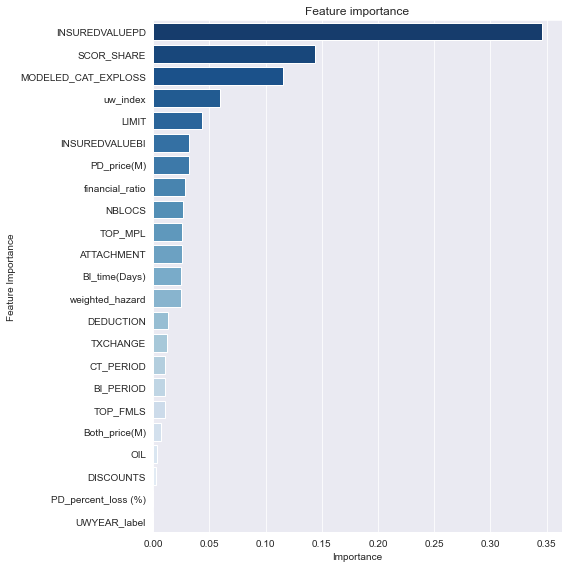

In [14]:
features_imp = naive_model.feature_importances_
features_names = X_test_num.columns.to_list()

df_feat = pd.DataFrame(features_names).rename(columns={0:'Feature Importance'})
df_feat['Importance'] = pd.Series(features_imp)
df_feat.sort_values(['Importance'], ascending=[0], inplace=True)

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x="Importance", y="Feature Importance", data=df_feat, palette="Blues_r")
ax.set_title('Feature importance')
plt.tight_layout()

In [15]:
# top 13 features have importance > 0.05
num_f_int = ['INSUREDVALUEPD', 'XXX_SHARE', 'MODELED_CAT_EXPLOSS',
                           'uw_index']

## 3. Filter method : Pearson's Correlation

We are in the case of a regression (numerical output) based on numerical variables (input). In this case, we should use ```PEARSON```'s correlation coefficient. The Scikit-Learn library provies the  ```f_regression()``` which is very helpful to compute PEARSON's correlation. Then, when each correlation score is computed, we can use the ```SelectKBest``` function to find the most relevant variables.

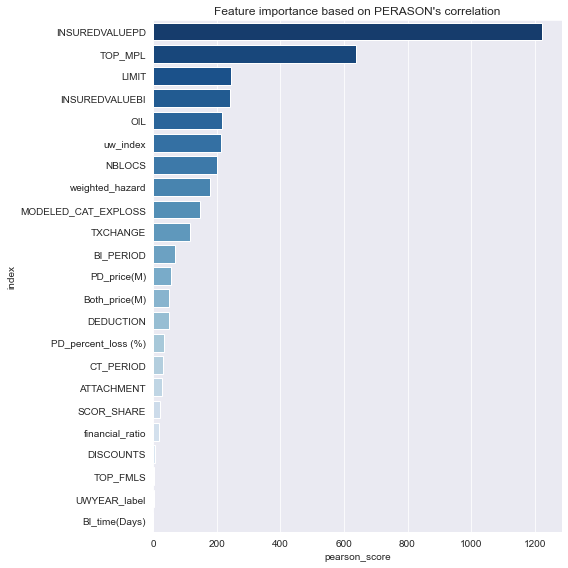

In [16]:
# define feature selection
fs = SelectKBest(score_func=f_regression, k=15)
# apply feature selection
X_selected_15 = fs.fit_transform(X_train_num, y_train)

#Rename columns in new dataset
mask = fs.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(X_train_num.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

X_selected_15 = pd.DataFrame(X_selected_15, columns=new_features)
scores = pd.DataFrame(data=fs.scores_, index=X_train_num.columns.values, columns=['pearson_score']).reset_index()
scores.sort_values(['pearson_score'], ascending=[0], inplace=True)
#scores.drop(columns=['TC_PROFIT_COMMISSION', 'PD_percent_tiv (%)', 'BI_percent_loss (%)', 'TXCHANGE', 'Both_percent_loss (%)'], inplace=True)
f_pearson = X_selected_15.columns.values

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x="pearson_score", y="index", data=scores, palette="Blues_r")
ax.set_title('Feature importance based on PERASON\'s correlation')
plt.tight_layout()

In [17]:
num_f_pearson = list(f_pearson)

# <font color='darkorange'> Categorical variables </font>
First, let's focus on categorical variables. 

## 1. Wrapper feature selection : Recursive Feature Elimination

Once again, let's perform our RFE on one-hot encoded dataset.



In [18]:
cols = ['DIVISION_NUM', 'SEGMENT_LOB', 'UWYEAR', 'MAINOCCUPANCY', 'SECTOR',
       'BUSINESSUNIT', 'UWCENTER', 'SCOPE_PERILS', 'SUBSIDIARY', 'PARTTYPE',
       'GUARANTEE', 'MAIN_PRICING_CATEG', 'BI_TYPE', 'WORDING',
       'QUALITY_RISK_MGT', 'ASSET_QUALITY', 'BI_MITIGATION', 'MB_QUALITY',
       'GEO_MARKET_SEGMENT', 'INCEPTION_month']

for c in cols:
    X_cat = pd.get_dummies(X_cat, prefix=[c], columns = [c], drop_first=True)
    
X_cat.head()

,COVER_BI,DIVISION_NUM_2,DIVISION_NUM_3,DIVISION_NUM_4,DIVISION_NUM_5,DIVISION_NUM_6,DIVISION_NUM_7,DIVISION_NUM_8,DIVISION_NUM_9,DIVISION_NUM_10,DIVISION_NUM_11,DIVISION_NUM_12,SEGMENT_LOB_Property Energy,UWYEAR_2018,UWYEAR_2019,UWYEAR_2020,MAINOCCUPANCY_Agricultural/Life Sciences/Agronomy,MAINOCCUPANCY_Airport Operator,MAINOCCUPANCY_Aluminium,MAINOCCUPANCY_Armed Forces/Police,MAINOCCUPANCY_Auto Parts,MAINOCCUPANCY_Automobile,MAINOCCUPANCY_Banking activities,MAINOCCUPANCY_Base Metals Mines,MAINOCCUPANCY_Beverages Producers,"MAINOCCUPANCY_Building (Apt, Office, Commercial)",MAINOCCUPANCY_Building Materials,MAINOCCUPANCY_Cable & Fibre,MAINOCCUPANCY_Chemical/Fertilizer/Explosives,MAINOCCUPANCY_Civil works,MAINOCCUPANCY_Coal mine underground,MAINOCCUPANCY_Coal mines,MAINOCCUPANCY_Commercial buildings,MAINOCCUPANCY_Components,MAINOCCUPANCY_Conglomerates,MAINOCCUPANCY_Contractors' equipment,MAINOCCUPANCY_Defence,MAINOCCUPANCY_Electricity Transmission & Distribution,MAINOCCUPANCY_Electronic equipment,MAINOCCUPANCY_Energy (Electricity),MAINOCCUPANCY_Engineering Firms,MAINOCCUPANCY_Exploration/Production/Separation,MAINOCCUPANCY_Fine chemicals,MAINOCCUPANCY_Food producers,MAINOCCUPANCY_Gas Processing (LNG/LPG/GTL),MAINOCCUPANCY_Gasturbines,MAINOCCUPANCY_General Retailers,MAINOCCUPANCY_Glass/Ceramic/Others,MAINOCCUPANCY_Government & Public Services,MAINOCCUPANCY_Healthcare Providers,MAINOCCUPANCY_Home & Personal Products,MAINOCCUPANCY_Home Builders,MAINOCCUPANCY_Hotels & Food Services/Casinos,MAINOCCUPANCY_Hydro,MAINOCCUPANCY_IT Services,MAINOCCUPANCY_Independants,MAINOCCUPANCY_Industrial Conglomerate,MAINOCCUPANCY_Industrial buildings,MAINOCCUPANCY_Inorganic chemistry - Fertilizer,MAINOCCUPANCY_Inspection & Verification Co.,MAINOCCUPANCY_Insurance,MAINOCCUPANCY_International Oil Companies,MAINOCCUPANCY_Investment Funds,MAINOCCUPANCY_Legal profession,MAINOCCUPANCY_Logistics/Trucking,MAINOCCUPANCY_Mass distribution,MAINOCCUPANCY_Materials - Cement,MAINOCCUPANCY_Mechanical industries,MAINOCCUPANCY_Media,MAINOCCUPANCY_Medical equipment & supplies,MAINOCCUPANCY_Metallurgy,MAINOCCUPANCY_Metalworking,MAINOCCUPANCY_Mines with smelting / refining,MAINOCCUPANCY_Mixed Generation,MAINOCCUPANCY_Multi-Activity Mining,...,MAIN_PRICING_CATEG_Gas Processing,MAIN_PRICING_CATEG_Glass/ Ceramic/Others,MAIN_PRICING_CATEG_High Tech Industries,MAIN_PRICING_CATEG_Infrastructure,MAIN_PRICING_CATEG_Leisure industry,MAIN_PRICING_CATEG_Mechanical industries,MAIN_PRICING_CATEG_Metal Works,MAIN_PRICING_CATEG_Metallurgy,MAIN_PRICING_CATEG_Midstream - Transportation/Storage,MAIN_PRICING_CATEG_Mining - Bulk commodities,MAIN_PRICING_CATEG_Mining - Hard Rock,MAIN_PRICING_CATEG_Mining - Other,MAIN_PRICING_CATEG_Mining - Underground coal,MAIN_PRICING_CATEG_Other Onshore,MAIN_PRICING_CATEG_Other categories,MAIN_PRICING_CATEG_Petrochemical,MAIN_PRICING_CATEG_Pharmaceuticals & fine chemicals,MAIN_PRICING_CATEG_Power,MAIN_PRICING_CATEG_Printing industry,MAIN_PRICING_CATEG_Public buildings,MAIN_PRICING_CATEG_Pulp & paper,MAIN_PRICING_CATEG_Rubber & Plastic Manufacturing,MAIN_PRICING_CATEG_Specialty chemicals,MAIN_PRICING_CATEG_Telecommunications & Media,MAIN_PRICING_CATEG_Textile industry,MAIN_PRICING_CATEG_Tobacco,MAIN_PRICING_CATEG_Transportation & Logistics,MAIN_PRICING_CATEG_Warehouse,MAIN_PRICING_CATEG_Waste Treatment,MAIN_PRICING_CATEG_Water Treatment,MAIN_PRICING_CATEG_Wood industry,BI_TYPE_Loss of profit,BI_TYPE_Standing Charges,WORDING_Standard,WORDING_Wide,QUALITY_RISK_MGT_Average,QUALITY_RISK_MGT_Average Minus,QUALITY_RISK_MGT_Average Plus,QUALITY_RISK_MGT_Below average,QUALITY_RISK_MGT_Good,QUALITY_RISK_MGT_Poor,ASSET_QUALITY_Average,ASSET_QUALITY_Average Minus,ASSET_QUALITY_Average Plus,ASSET_QUALITY_Below average,ASSET_QUALITY_Good,BI_MITIGATION_Average,BI_MITIGATION_Average Minus,BI_MITIGATION_Average Plus,BI_MITIGATION_Below average,BI_MITIGATION_Good,BI_MITIGATION_Non applicable,BI_MITIGATION_Poor,MB_QUALITY_Average,MB_QUALITY_Average Minus,MB_QUALITY_Average 

In [19]:
model = RandomForestRegressor(random_state=42)
selector = RFE(model, step=1, verbose = 1)
selector = selector.fit(X_cat, y)

Fitting estimator with 214 features.
Fitting estimator with 213 features.
Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
F

In [20]:
f = selector.get_support(1) #the most important features
X_cat[X_cat.columns[f]].head() # final features`

,COVER_BI,DIVISION_NUM_2,DIVISION_NUM_3,DIVISION_NUM_4,SEGMENT_LOB_Property Energy,UWYEAR_2018,UWYEAR_2019,UWYEAR_2020,MAINOCCUPANCY_Auto Parts,MAINOCCUPANCY_Automobile,MAINOCCUPANCY_Base Metals Mines,MAINOCCUPANCY_Chemical/Fertilizer/Explosives,MAINOCCUPANCY_Coal mine underground,MAINOCCUPANCY_Defence,MAINOCCUPANCY_Electronic equipment,MAINOCCUPANCY_Exploration/Production/Separation,MAINOCCUPANCY_Fine chemicals,MAINOCCUPANCY_Food producers,MAINOCCUPANCY_Gas Processing (LNG/LPG/GTL),MAINOCCUPANCY_Gasturbines,MAINOCCUPANCY_General Retailers,MAINOCCUPANCY_Government & Public Services,MAINOCCUPANCY_Hotels & Food Services/Casinos,MAINOCCUPANCY_Independants,MAINOCCUPANCY_International Oil Companies,MAINOCCUPANCY_Media,MAINOCCUPANCY_Metallurgy,MAINOCCUPANCY_Mixed Generation,MAINOCCUPANCY_Multi-Activity Mining,MAINOCCUPANCY_Multi-occupancy industrial,MAINOCCUPANCY_National Oil Companies,MAINOCCUPANCY_Other mines,MAINOCCUPANCY_Petrochemical (Major agents),MAINOCCUPANCY_Petrochemical / Fertilizer,MAINOCCUPANCY_Petrochemical / Polymers,MAINOCCUPANCY_Precious Metals Mines,MAINOCCUPANCY_Pulp & paper,MAINOCCUPANCY_Railways,MAINOCCUPANCY_Refining/Upgrading,MAINOCCUPANCY_Telecommunications,MAINOCCUPANCY_Thermal,MAINOCCUPANCY_Transmission/Storage/Distribution,SECTOR_BS Energy,BUSINESSUNIT_BS Property,UWCENTER_LAC,UWCENTER_UNITED STATES,SCOPE_PERILS_Named Perils,SUBSIDIARY_XXX CANADA,SUBSIDIARY_XXX RE US,SUBSIDIARY_XXX REASSURANCE,SUBSIDIARY_XXX SWITZERLAND,SUBSIDIARY_XXX UK,PARTTYPE_Quota-Share,GUARANTEE_PFF,MAIN_PRICING_CATEG_Automotive & Parts,MAIN_PRICING_CATEG_Chemicals,MAIN_PRICING_CATEG_Commercial buildings,MAIN_PRICING_CATEG_Crude Processing - Refining,MAIN_PRICING_CATEG_Food producers,MAIN_PRICING_CATEG_Gas Processing,MAIN_PRICING_CATEG_High Tech Industries,MAIN_PRICING_CATEG_Metal Works,MAIN_PRICING_CATEG_Metallurgy,MAIN_PRICING_CATEG_Midstream - Transportation/Storage,MAIN_PRICING_CATEG_Mining - Bulk commodities,MAIN_PRICING_CATEG_Mining - Hard Rock,MAIN_PRICING_CATEG_Petrochemical,MAIN_PRICING_CATEG_Power,MAIN_PRICING_CATEG_Public buildings,MAIN_PRICING_CATEG_Pulp & paper,MAIN_PRICING_CATEG_Telecommunications & Media,MAIN_PRICING_CATEG_Warehouse,MAIN_PRICING_CATEG_Waste Treatment,BI_TYPE_Loss of profit,BI_TYPE_Standing Charges,WORDING_Standard,WORDING_Wide,QUALITY_RISK_MGT_Average,QUALITY_RISK_MGT_Average Minus,QUALITY_RISK_MGT_Average Plus,ASSET_QUALITY_Average,ASSET_QUALITY_Average Minus,ASSET_QUALITY_Average Plus,ASSET_QUALITY_Good,BI_MITIGATION_Average,BI_MITIGATION_Average Minus,BI_MITIGATION_Average Plus,BI_MITIGATION_Non applicable,MB_QUALITY_Average,GEO_MARKET_SEGMENT_Central and Eastern Europe,GEO_MARKET_SEGMENT_Emerging Asia,GEO_MARKET_SEGMENT_Latin America,GEO_MARKET_SEGMENT_Mature Asia,GEO_MARKET_SEGMENT_Middle East,GEO_MARKET_SEGMENT_North America,GEO_MARKET_SEGMENT_Western Europe,INCEPTION_month_2,INCEPTION_month_3,INCEPTION_month_4,INCEPTION_month_5,INCEPTION_month_6,INCEPTION_month_7,INCEPTION_month_8,INCEPTION_month_9,INCEPTION_month_10,INCEPTION_month_11,INCEPTION_month_12
0,True,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,True,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,True,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,True,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,

In [21]:
cat_f_rfe = ['COVER_BI', 'DIVISION_NUM', 'SEGMENT_LOB', 'UWYEAR', 'MAINOCCUPANCY', 'SECTOR', 'BUSINESSUNIT', 'UWCENTER']

In [22]:
## 3. Intrinsic method 

In [23]:
naive_model = RandomForestRegressor(random_state=42)
naive_model.fit(X_cat, y)

RandomForestRegressor(random_state=42)

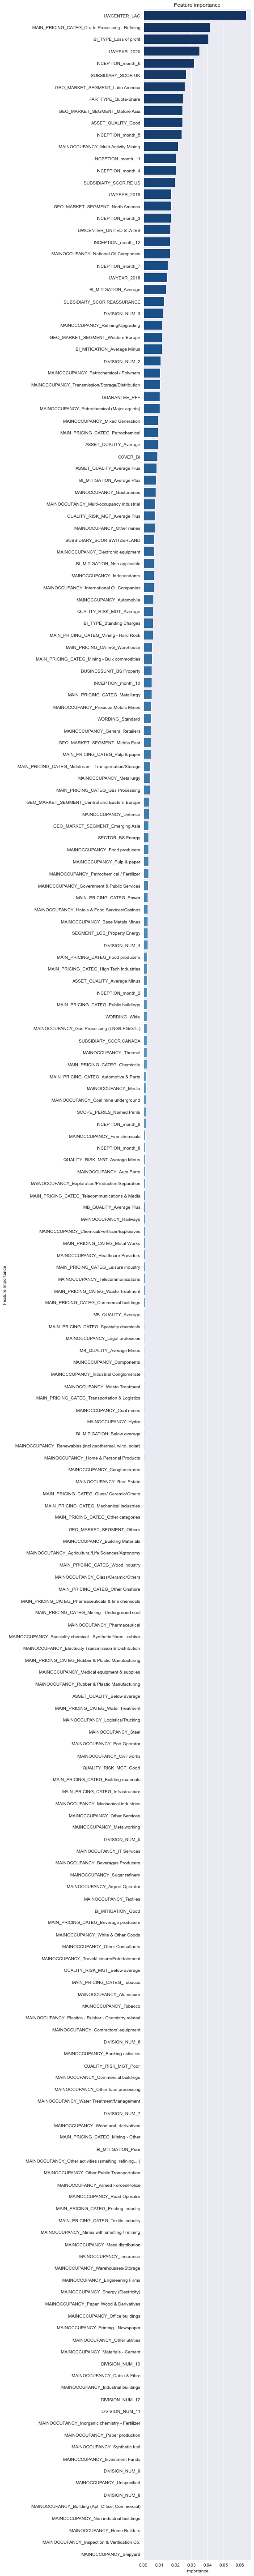

In [24]:
features_imp = naive_model.feature_importances_
features_names = X_cat.columns.to_list()

df_feat = pd.DataFrame(features_names).rename(columns={0:'Feature Importance'})
df_feat['Importance'] = pd.Series(features_imp)
df_feat.sort_values(['Importance'], ascending=[0], inplace=True)

fig, ax = plt.subplots(figsize=(8,80))
ax = sns.barplot(x="Importance", y="Feature Importance", data=df_feat, palette="Blues_r")
ax.set_title('Feature importance')
plt.tight_layout()



In [25]:
# selecting features with importance > 0.03
cat_f_int = ['UWCENTER', 'MAIN_PRICING_CATEG', 'BI_TYPE', 'UWYEAR', 
                      'INCEPTION'
                     ]

## 3. Filter method : Anova's Correlation

We are in the case of a regression (numerical output) based on categorical variables (input). In this case, we should use ```ANOVA```'s correlation coefficient. The Scikit-Learn library provies the  ```f_classif()``` which is very helpful to compute ANOVA's correlation. Then, when each correlation score is computed, we can use the ```SelectKBest``` function to find the most relevant variables.

As we have one-hot encoded our entire dataset, we have to keep a large number of variables $k=150$ to make sure that we retain each 'family' of most important variables.

/Users/liuxuwen/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


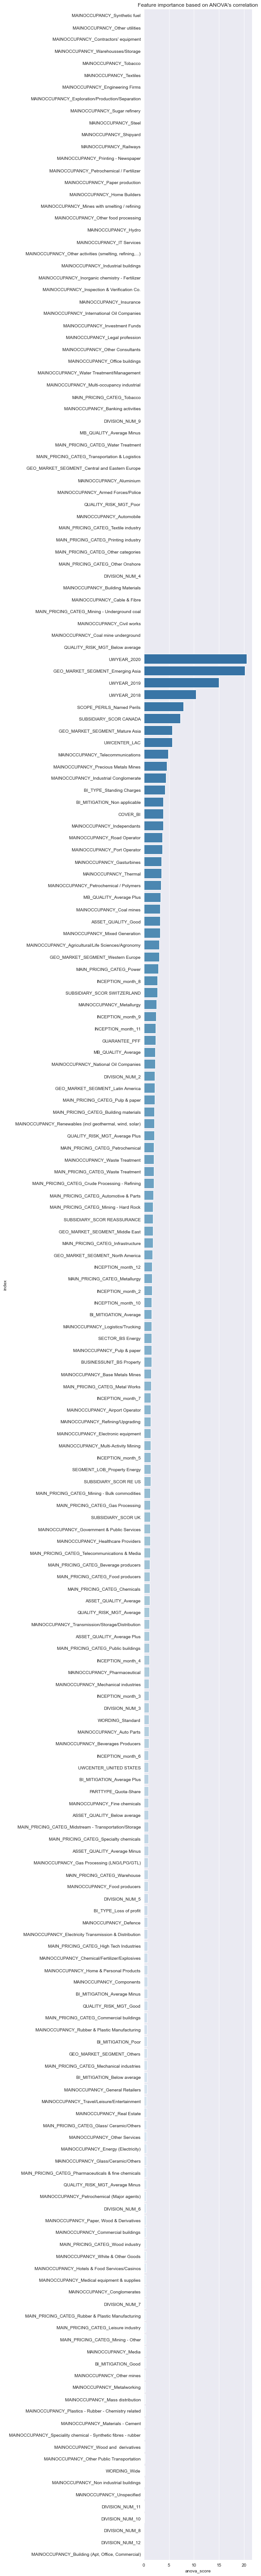

In [26]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=50)
# apply feature selection
X_selected_150 = fs.fit_transform(X_cat, y)

#Rename columns in new dataset
mask = fs.get_support() #list of booleans
new_features = [] # The list of your K best features
feature_names = list(X_cat.columns.values)

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

X_selected_150 = pd.DataFrame(X_selected_150, columns=new_features)
scores = pd.DataFrame(data=fs.scores_, index=X_cat.columns.values, columns=['anova_score']).reset_index()
scores.sort_values(['anova_score'], ascending=[0], inplace=True)
#scores.drop(columns=['TC_PROFIT_COMMISSION', 'PD_percent_tiv (%)', 'BI_percent_loss (%)', 'TXCHANGE', 'Both_percent_loss (%)'], inplace=True)
f_anova = X_selected_150.columns.values

fig, ax = plt.subplots(figsize=(8,80))
ax = sns.barplot(x="anova_score", y="index", data=scores, palette="Blues_r")
ax.set_title('Feature importance based on ANOVA\'s correlation')
plt.tight_layout()

In [27]:
# selecting features with anova > 5
cat_f_anova = ['UWYEAR', 'GEO_MARKET_SEGMENT', 'SCOPE_PERILS', 'SUBSIDIARY', 'UWCENTER']


## Conclusion

The features selected are roughly the same for the different methods. We will remember that those are the most important ones. This will be important as it's difficult to train a model with around 50 features. We will apply the different models on different subsets and see which one performs the best. 

This will also be very important to help us understand how ```PREMIUM``` fixing at XXX works. On a logical point of vue, it makes totally sense taht those are the most important. For example, we can easily understand why the ```INSUREDVALUEPD``` is the most important factor for defining the ```PREMIUM```. If the value to insure increases, the ```PREMIUM``` should also increases.  

From these analysis, we can conclude that the important features are:

For numerical variables (we take the union of the features found by teh three methods) :




In [28]:
num_f_final = list(set(num_f_rfe + num_f_int +  num_f_pearson))
sorted(num_f_final)

['BI_PERIOD',
 'BI_time(Days)',
 'Both_price(M)',
 'DEDUCTION',
 'INSUREDVALUEBI',
 'INSUREDVALUEPD',
 'LIMIT',
 'MODELED_CAT_EXPLOSS',
 'NBLOCS',
 'OIL',
 'PD_percent_loss (%)',
 'PD_price(M)',
 'XXX_SHARE',
 'TOP_MPL',
 'TXCHANGE',
 'financial_ratio',
 'uw_index',
 'weighted_hazard']




For categorical variables(also taking the union):



In [29]:
cat_f_final = list(set(cat_f_rfe + cat_f_int + cat_f_anova))
cat_f_final

['SUBSIDIARY',
 'INCEPTION',
 'SEGMENT_LOB',
 'BUSINESSUNIT',
 'DIVISION_NUM',
 'UWCENTER',
 'MAIN_PRICING_CATEG',
 'BI_TYPE',
 'SECTOR',
 'UWYEAR',
 'MAINOCCUPANCY',
 'COVER_BI',
 'SCOPE_PERILS',
 'GEO_MARKET_SEGMENT']